In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
data = pd.read_csv('Dataset/HaNoi.csv')

In [3]:
# lấy dữ liệu và sắp xếp lại thứ tự
data['date'] = pd.to_datetime(data['date'], dayfirst = True)
data = data.sort_values('date')

# Lấy chỉ số AQI và ngày
dates = data['date'].values
aqi_values = data['AQI'].values.reshape(-1, 1)

In [4]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
aqi_values = scaler.fit_transform(aqi_values)

In [5]:
# Hàm tạo chuỗi 
def create_sequences(data, dates, seq_length):
    xs, ys, ds = [], [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        d = dates[i + seq_length]
        xs.append(x)
        ys.append(y)
        ds.append(d)
    return np.array(xs), np.array(ys), np.array(ds)

seq_length = 30  # Thay đổi nếu muốn
x, y, d = create_sequences(aqi_values, dates, seq_length)

In [6]:
# Hàm chia dữ liệu train và test
def train_test_split(x, y, d, train_ratio):
    train_size = int(len(x) * train_ratio)
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    d_train, d_test = d[:train_size], d[train_size:]
    return x_train, x_test, y_train, y_test, d_train, d_test

ratios = [0.9, 0.8, 0.7]
splits = [train_test_split(x, y, d, ratio) for ratio in ratios]

In [7]:
# Hàm xây dựng model
def build_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, 
                        activation = "tanh", 
                        return_sequences=True, 
                        input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50, 
                        activation = "tanh", 
                        return_sequences=True))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50, 
                        activation = "tanh", 
                        return_sequences=True))
    model.add(SimpleRNN(50))
    model.add(Dense(units = 1,activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [8]:
# Hàm MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
#Huấn luyện model 
results = []
num_epochs = 50  # Thay đổi số lượng epoch nếu cần

for (x_train, x_test, y_train, y_test, d_train, d_test), ratio in zip(splits, ratios):
    model = build_model((seq_length, 1))
    model.fit(x_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)
    
    y_pred = model.predict(x_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test)
    y_train = scaler.inverse_transform(y_train)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    results.append((ratio, mse, rmse, mae, mape, y_train, y_test, y_pred, d_train, d_test))
    print(f"Train:Test Ratio: {ratio:.1f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Train:Test Ratio: 0.9, MSE: 763.2065, RMSE: 27.6262, MAE: 22.0334, MAPE: 29.4822
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Train:Test Ratio: 0.8, MSE: 661.8571, RMSE: 25.7266, MAE: 19.3429, MAPE: 24.4680
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Train:Test Ratio: 0.7, MSE: 620.9484, RMSE: 24.9188, MAE: 19.0873, MAPE: 29.3465


In [10]:
# RMSE của 7:3 cho kết quả tốt nhất nên sẽ sử dụng cho dự đoán
# Kết qủa của tuple (ratio, mse, rmse, mae, y_train, y_test, y_pred, d_train, d_test), ta chỉ cần 5 chỉ số cuối
_, _, _, _, _, y_train, y_test, y_pred, d_train, d_test = results[-1]

# Hàm dự đoán tương lai
def predict_future(model, last_sequence, n_steps, scaler):
    future_predictions = []
    current_sequence = last_sequence
    
    for _ in range(n_steps):
        next_value = model.predict(current_sequence.reshape(1, seq_length, 1))
        future_predictions.append(next_value[0, 0])
        current_sequence = np.append(current_sequence[1:], next_value, axis=0)
    
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)
    return future_predictions


In [11]:
# Dự đoán 30, 60 và 90 ngày tiếp từ sequence cuối cùng của gía trị của tập test data
last_sequence_test = aqi_values[-len(y_test) - seq_length:-len(y_test)]
future_30 = predict_future(model, last_sequence_test, 30, scaler)
future_60 = predict_future(model, last_sequence_test, 60, scaler)
future_90 = predict_future(model, last_sequence_test, 90, scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━

In [12]:
# Bắt đầu lấy từ ngày kế tiếp sau ngày cuối cùng của test
last_date = dates[-1]
future_dates_30 = pd.date_range(last_date, periods=31)[1:]  
future_dates_60 = pd.date_range(last_date, periods=61)[1:]  
future_dates_90 = pd.date_range(last_date, periods=91)[1:] 

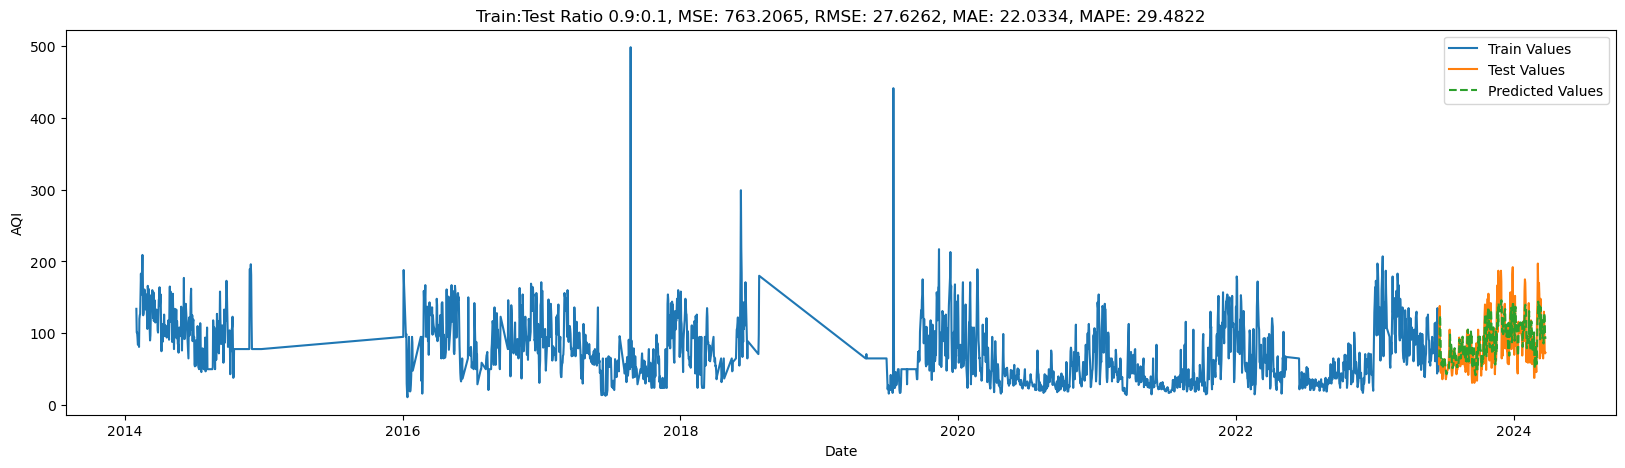

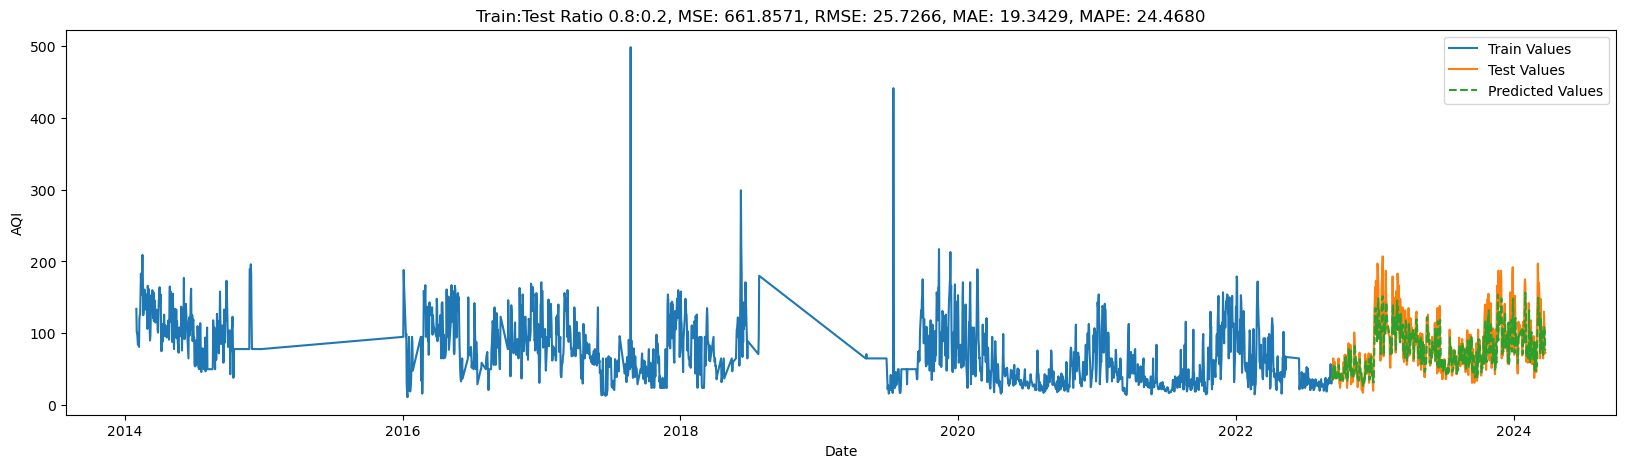

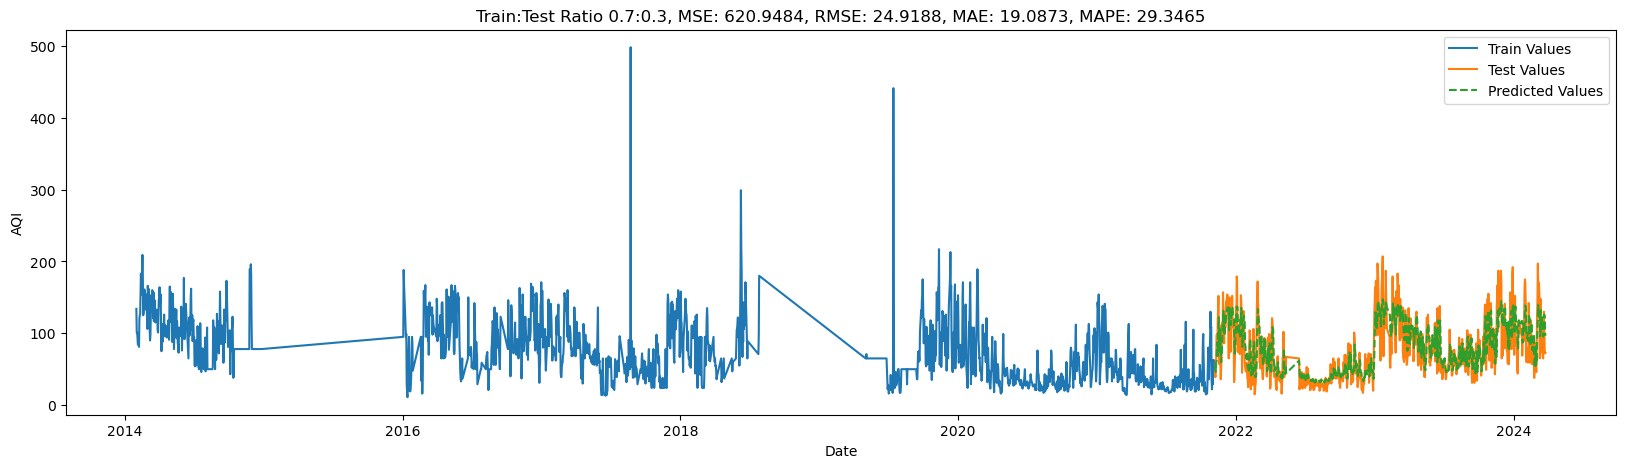

In [13]:
# Vẽ biểu đồ so sánh giữa train, test và predict
for i, (ratio, mse, rmse, mae, mape, y_train, y_test, y_pred, d_train, d_test) in enumerate(results):
    plt.figure(figsize=(20, 5))
    plt.plot(d_train, y_train, label='Train Values')
    plt.plot(d_test, y_test, label='Test Values')
    plt.plot(d_test, y_pred, label='Predicted Values', linestyle='dashed')
    plt.title(f'Train:Test Ratio {ratios[i]:.1f}:{1-ratios[i]:.1f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

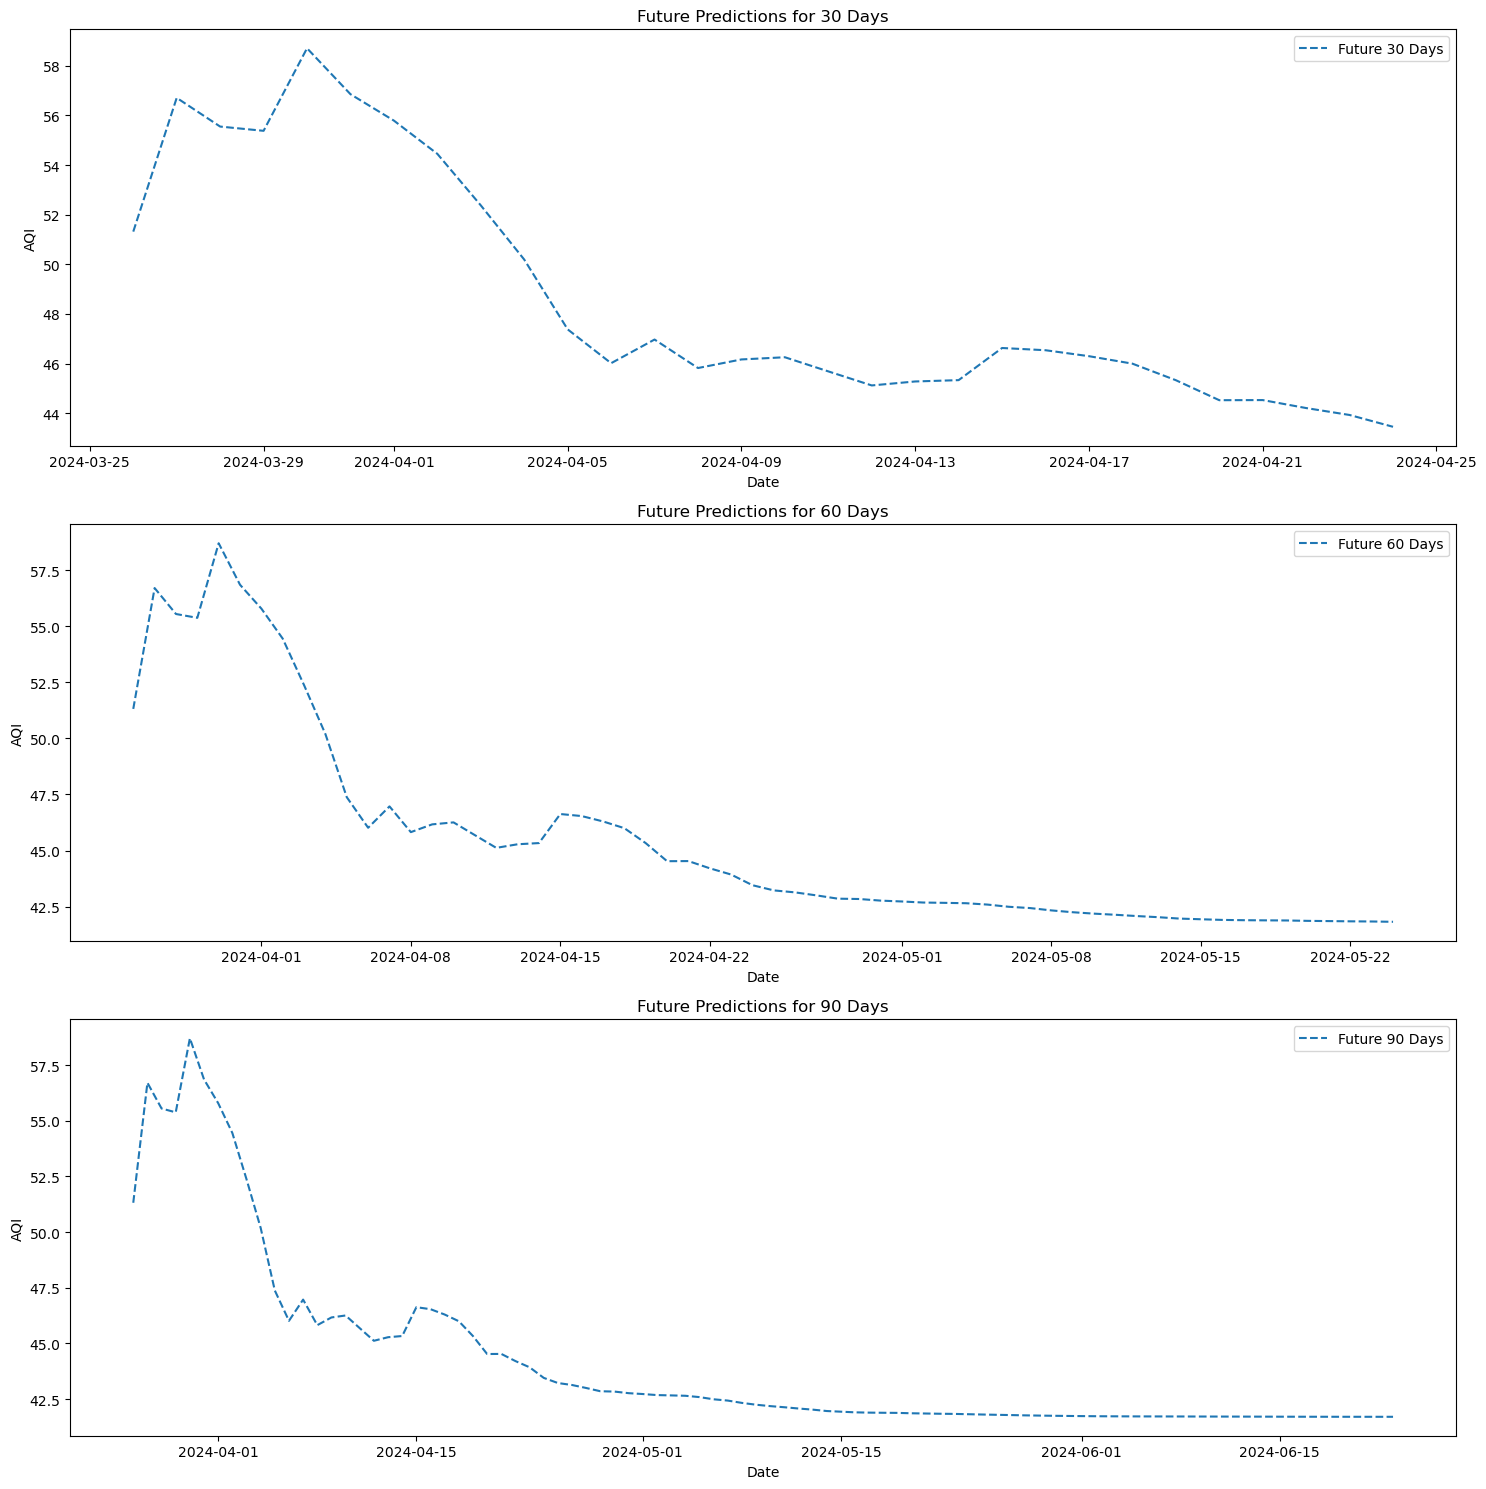

In [14]:
plt.figure(figsize=(15, 15))

# Dự đoán cho 30 ngày 
plt.subplot(3, 1, 1)
plt.plot(future_dates_30, future_30, label='Future 30 Days', linestyle='dashed')
plt.title('Future Predictions for 30 Days')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()

# Dự đoán cho 60 ngày 
plt.subplot(3, 1, 2)
plt.plot(future_dates_60, future_60, label='Future 60 Days', linestyle='dashed')
plt.title('Future Predictions for 60 Days')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()

# Dự đoán cho 90 ngày 
plt.subplot(3, 1, 3)
plt.plot(future_dates_90, future_90, label='Future 90 Days', linestyle='dashed')
plt.title('Future Predictions for 90 Days')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()

plt.tight_layout()
plt.show()